# Study the whistler instabilities associated with the whistler waves reported in Ivan's 2018 PRL 

In [1]:
import numpy as np
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
mpl.rcParams['legend.fontsize'] = 14
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points

%load_ext autoreload
%autoreload 2
%matplotlib inline

- fce ~ 2.5 kHz
- fpe ~ 16 kHz
- ne ~ 3.2 cc
- nh ~ 0.65 ne
- nh ~ 2 cc
- Th_par ~ 4.3 keV

- B0 ~ 87 nT

beta_h = 0.458
beta_p = 0.0117


In [171]:
def fast_freq_fn(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return kdi * np.sqrt(1 + kdi**2 * cos_theta**2)

def ea_freq_fn(k, theta, aol, the_tp, nc_nh):
    kz, kp = kzkp(k, theta)
    mp_me = 1836
    num = kz * np.sqrt(0.5 * nc_nh/(1+nc_nh) * the_tp * mp_me)
    k_rhose_2 = kp**2 * 0.5 * nc_nh/(1+nc_nh) * the_tp / mp_me
    kp_debye_2 = (kz**2+kp**2) * 0.5 * aol**2 * the_tp
    denom = np.sqrt(1 + k_rhose_2 + kp_debye_2)
    return num / denom
    
def kdi_2_krhoi(kdi, betap):
    return kdi * np.sqrt(betap)

def get_transport_ratios(k_list, freq_arr):
    ex_ez_list = []
    ey_ez_list = []
    ex_ey_list = []
    by_bx_list = []
    ex_by_list = []
    
    eigen_e_list = []
    eigen_b_list = []
    
    dt_list = []

    for i in range(len(k_list)):
        freq_i = freq_arr[i]
        kz, kp = kzkp(k_list[i], theta)
#         inp = input_gen(freq_i, kp, kz, betap)
        inp = input_gen(freq_i, kz, kp, betap, t_list, \
              a_list, n_list, q_list, m_list, v_list, \
              n, method = method, aol=aol)
    
        tr = transport_ratios(inp, print_result = False)
        eigen_e = tr['eigen_e']
        kvec = np.array([kp, 0, kz])
        khat = kvec/np.linalg.norm(kvec)
        ez_prime = np.dot(eigen_e, khat) * khat
        ey_prime = np.array([0, eigen_e[1], 0])
        ex_prime = eigen_e - ez_prime - ey_prime
        ex_ez = np.linalg.norm(ex_prime) / np.linalg.norm(ez_prime)
        ey_ez = np.linalg.norm(ey_prime) / np.linalg.norm(ez_prime)
        ex_ey = np.linalg.norm(ex_prime) / np.linalg.norm(ey_prime)
        ex_ez_list.append(ex_ez)
        ey_ez_list.append(ey_ez)
        ex_ey_list.append(ex_ey)
        
        eigen_e_list.append(eigen_e)

        eigen_b = np.cross(kvec, eigen_e)
        bz_prime = np.dot(eigen_b, khat) * khat
        by_prime = np.array([0, eigen_b[1], 0])
        bx_prime = eigen_b - bz_prime - by_prime
        by_bx = np.linalg.norm(bx_prime) / np.linalg.norm(by_prime)
        by_bx_list.append(by_bx)
        
        ex_by = np.linalg.norm(ex_prime) / np.linalg.norm(by_prime)
        ex_by_list.append(ex_by)
        
        eigen_b_list.append(eigen_b)
    return {'exez': ex_ez_list, 'eyez': ey_ez_list, 'exey': ex_ey_list, \
            'bybx': by_bx_list, 'exby': ex_by_list, 'eigen_e':eigen_e_list, 'eigen_b':eigen_b_list}

In [141]:
b0 = 87e-9 # T
nh = 2e6 # m^-3

betah = 2 * (1.26e-6) * nh * 4.3e3 * 1.6e-19 / b0**2
th_tp = 60
tc_th = 1e-3
nh_n0 = 0.5
betap = betah * (1/nh_n0) / th_tp

aol = np.sqrt(8.85e-12 * b0**2 / (nh / nh_n0 * 1.67e-27))

print('va/c = {0:.3g}'.format(aol))
print('beta_h = {0:.3g}'.format(betah))
print('beta_p = {0:.3g}'.format(betap))

va/c = 0.00317
beta_h = 0.458
beta_p = 0.0153


In [147]:
t_list=[1., th_tp, th_tp * tc_th]
a_list=[1., 2., 1.]
n_list=[1., nh_n0, 1-nh_n0] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=[0.,0.,0.]
n = 10
method = 'pade'
theta = 5.

kdi = 5

target_kde = 2.
target_kdi = target_kde * np.sqrt(1836)

k = kdi_2_krhoi(kdi, betap)
kz, kp = kzkp(k, theta)
print(k, kz, kp)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

0.6178735605455574 0.6155223651065534 0.0538512290934882


In [148]:
target_k = kdi_2_krhoi(target_kdi, betap)
print('target_k = {0:.2f}'.format(target_k))
print('target_kde = {0:.3g}'.format(target_kdi / np.sqrt(1836.)))

# ELECTRON ACOUSTIC MODE

ea_seed_freq = ea_freq_fn(k, theta, aol, th_tp, nc_nh=n_list[2]/n_list[1])

f = lambda wrel:\
    real_imag(disp_det(list_to_complex(wrel), kz, kp, betap,
                              t_list, a_list, n_list, q_list, \
                              m_list, v_list, method = 'numpy', n = 6, \
                              aol=aol))
ea_guess = ea_seed_freq * (1-.5j) 
print('ea_seed_freq = {0:.3g}'.format(ea_guess))

wr, wi = scipy.optimize.fsolve(f, real_imag(ea_guess))

print('wr = {0:.3g}'.format(wr))
print('wi = {0:.3g}'.format(wi))
ea_freq = follow_k(ea_guess, target_k, param,
                log_incrmt = 0.03, incrmt_method = 'log')

target_k = 10.59
target_kde = 2
ea_seed_freq = 102-51.1j
wr = 103
wi = -57.3


In [149]:
# WHISTLER MODE

whistler_seed_freq = fast_freq_fn(k, theta, betap)
f = lambda wrel:\
    real_imag(disp_det(list_to_complex(wrel), kz, kp, betap,
                              t_list, a_list, n_list, q_list, \
                              m_list, v_list, method = 'numpy', n = 6, \
                              aol=aol))
whistler_guess = whistler_seed_freq 
print('whistler_seed_freq = {0:.3g}'.format(whistler_guess))

wr, wi = scipy.optimize.fsolve(f, real_imag(whistler_guess))

print('wr = {0:.3g}'.format(wr))
print('wi = {0:.3g}'.format(wi))
whistler_freq = follow_k(whistler_guess, target_k, param,
                log_incrmt = 0.03, incrmt_method = 'log')

whistler_seed_freq = 25.4
wr = 31.1
wi = -0.0445


In [150]:
kde_start = kdi / np.sqrt(1836)
kde_end = np.sqrt(ea_freq[1][0]**2 + ea_freq[1][1]**2) /np.sqrt(1836) / np.sqrt(betap)
ea_freq_arr = np.array(ea_freq[-1])
kde_list = np.logspace(np.log10(kde_start), np.log10(kde_end), len(ea_freq_arr))

whistler_freq_arr = np.array(whistler_freq[-1])

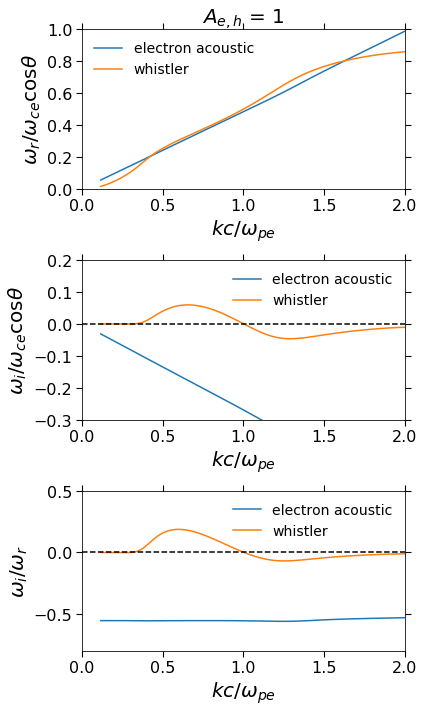

In [151]:
plt.figure(figsize=[6, 10])

title = r'$A_{e, h}$' +' = {0:.3g}'.format(a_list[1] - 1)

plt.subplot(311)
plt.plot(kde_list, ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), '-', label = 'electron acoustic')
plt.plot(kde_list, whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), '-', label = 'whistler')
# plt.plot(kde_whistler, freq_whistler.real)
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylim([0, 1.])
plt.xlim([0, 2])
plt.legend(frameon=False)
plt.title(title)

plt.subplot(312)
plt.plot(kde_list, ea_freq_arr.imag/1836/np.cos(np.deg2rad(theta)), label = 'electron acoustic')
plt.plot(kde_list, whistler_freq_arr.imag/1836/np.cos(np.deg2rad(theta)), label = 'whistler')
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylim([-.3, .2])
plt.xlim([0, 2])
plt.legend(frameon=False)
plt.axhline(0, color = 'k', linestyle = 'dashed')
plt.tight_layout()

plt.subplot(313)
plt.plot(kde_list, ea_freq_arr.imag/ea_freq_arr.real, label = 'electron acoustic')
plt.plot(kde_list, whistler_freq_arr.imag/whistler_freq_arr.real, label = 'whistler')
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_i/\omega_r$')
plt.ylim([-.8, .5])
plt.xlim([0, 2])
plt.legend(frameon=False)
plt.axhline(0, color = 'k', linestyle = 'dashed')

plt.tight_layout()
#
# file_name = 'figure/whistler_ea_dispersion_a={0}.png'.format(a_list[1] - 1)
plt.savefig(file_name, dpi=100)

In [172]:
k_end = np.sqrt(ea_freq[1][0]**2 + ea_freq[1][1]**2)
k_start = kdi_2_krhoi(kdi, betap)
k_list = np.logspace(np.log10(k_start), np.log10(k_end), len(ea_freq_arr))

ea_tr = get_transport_ratios(k_list, ea_freq_arr)
whistler_tr = get_transport_ratios(k_list, whistler_freq_arr.real)

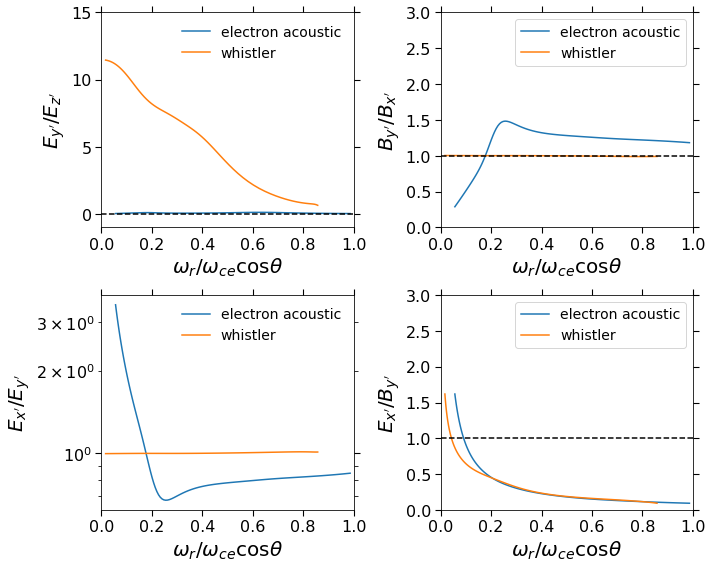

In [183]:
plt.figure(figsize=[10, 8])

plt.subplot(221)
plt.plot(ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), np.array(ea_tr['eyez']), label='electron acoustic')
plt.plot(whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), np.array(whistler_tr['eyez']), label = 'whistler')
plt.xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylabel('$E_{y^\prime}/E_{z^\prime}$')
plt.axhline(0, linestyle='dashed', color='k')
plt.ylim([-1, 15])
plt.xlim([0, 1])
# plt.yscale('log')
plt.legend(frameon=False)


plt.subplot(222)
plt.plot(ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), ea_tr['bybx'], label='electron acoustic')
plt.plot(whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), whistler_tr['bybx'], label='whistler')
plt.xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylabel('$B_{y^\prime}/B_{x^\prime}$')
plt.axhline(1, linestyle='dashed', color='k')
plt.ylim([0, 3])
plt.xlim([0, 1])
plt.legend()

plt.subplot(223)
plt.plot(ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), np.array(ea_tr['exey']), label='electron acoustic')
plt.plot(whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), np.array(whistler_tr['exey']), label = 'whistler')
plt.xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylabel('$E_{x^\prime}/E_{y^\prime}$')
plt.axhline(0, linestyle='dashed', color='k')
# plt.ylim([-1, 6])
# plt.ylim([-.2, .2])
plt.xlim([0, 1])
plt.yscale('log')
plt.legend(frameon=False)

plt.subplot(224)
plt.plot(ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), ea_tr['exby'], label='electron acoustic')
plt.plot(whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), whistler_tr['exby'], label='whistler')
plt.xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylabel('$E_{x^\prime}/B_{y^\prime}$')
plt.axhline(1, linestyle='dashed', color='k')
plt.ylim([0, 3])
plt.xlim([0, 1])
plt.legend()

plt.tight_layout()


In [176]:
1/np.array(ea_tr['exez'])

array([ 8.82478849,  8.82245561,  8.82009263,  8.81771207,  8.81532906,
        8.81296177,  8.81063183,  8.80836491,  8.80619131,  8.80414668,
        8.8022728 ,  8.80061853,  8.79924086,  8.79820609,  8.79759116,
        8.79748508,  8.79799048,  8.79922516,  8.80132347,  8.80443741,
        8.80873716,  8.81441059,  8.82166145,  8.83070606,  8.84176849,
        8.85507559,  8.87085483,  8.88934122,  8.91080481,  8.93561699,
        8.96438254,  8.99817291,  9.03890134,  9.08987641,  9.15654924,
        9.2474177 ,  9.37495688,  9.55630019,  9.81322318, 10.17086824,
       10.65475576, 11.28610952, 12.07631284, 13.02200755, 14.10247571,
       15.28039831, 16.50615123, 17.72478529, 18.8839719 , 19.94081625,
       20.86586771, 21.64377854, 22.27125842, 22.75362632, 23.10121702,
       23.32643729, 23.44175554, 23.45856129, 23.38667797, 23.23429452,
       23.00812632, 22.71367624, 22.35551923, 21.93757162, 21.46333042,
       20.93608196, 20.3590863 , 19.73574718, 19.06977874, 18.36